# Skin Cancer Detection using various CNN models

Cancer is a disease in which cells are developed abnormally and they divide uncontrollably. This in turn has the ability to infiltrate and destroy normal body tissue. Skin cancer is by far the most common type of cancer. If detected early, it is highly treatable.

Deep learning in the field of image processing has shown exceptional results. The aim of this project is to do skin cancer detection using Convolutional Neural Networks (CNN) and transfer learning. The goal is to create such a model that it can detect from a scan if the cancer is benign or malignant, so that it is detected and appropriate medical treatment can be provided for its cure.

TensorFlow library is used for the deep learning. 

In this notebook, we will be extending our previous notebook submitted with Xception, VGG16 and resnet-50 Convolutional Neural Network (CNN). This will help us in conclusing the best model for our use case.

### Importing the libraries

The required libraries are imported.

In [161]:
# import libraries
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Dropout, Activation, Dense
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import pandas as pd
import plotly.express as px
import os

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

### Creating the directories for Kaggle

Directories for train, test and output folders are created.

The image dimension is also set for 299 pixels based upon the data.

In [162]:
trainFolder = "../input/skin-cancer-malignant-vs-benign/train/"
testFolder = "../input/skin-cancer-malignant-vs-benign/test/"
outputDir = "/kaggle/working/"
imgDim = 299

### Generalized Mean Pooling

Generalized Mean Pooling computes the generalized mean of each channel of a tensor. It helps focus on the salient features of the image.

In [163]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool

### Base Model for Xception

We have defined a function "getBaseModel_xception" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [164]:
def getBaseModel_xception(freezedLayers):
    model = Xception(input_shape=(imgDim,imgDim,3),weights='imagenet',include_top=False)
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers for Xception

A function "getAttachmentForModel_xception" is defined in which The additional layers are defined for training i.e., 3 hidden (dropout, activation and dense) layers and 1 output layer.

In [165]:
def getAttachmentForModel_xception(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = Dropout(0.05)(X)
    X = Activation('relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model for Xception

The "getFinalModel_xception" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [166]:
def getFinalModel_xception(baseModel):
    attachment = getAttachmentForModel_xception(baseModel)
    imageInput = Input((299,299,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Save History

The "saveHistoryFile" fuction saves the history including the accuracy for each epoch into a csv file. This can be used later on for visualizations and drawing conclusions.

In [167]:
def saveHistoryFile(freezedLayers,model,filename):
    df = pd.DataFrame(model.history)
#     with open(f'{outputDir}{freezedLayers}.json','w') as f:
    df.index.name = "Epoch"
    df["freezed_layer"] = f"{freezedLayers}"
    if os.path.isfile(f'{outputDir}{filename}.csv'):
        exist_df = pd.read_csv(f'{outputDir}{filename}.csv')
        final_df = pd.concat([exist_df, df])
    else:
        final_df = df
    final_df.to_csv(f'{outputDir}{filename}.csv')


### Image Augmentation

This is a technique that is used to expand the dataset artificially. We have set the attributes of "rescale" to 1/255, "shear_range" to 0.2, "zoon_range" to 0.2 and "horizontal_flip" as True for both train dataset as well as test dataset.

We have defined the train and test folders, targert_size as 299 pixels by 299 pixels, batch_size as 48 images and class_mode as "categorical" for both train and test dataset.

In [168]:
trainGenerator = ImageDataGenerator(
    rescale = 1./255,                                     
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGenerator = ImageDataGenerator(rescale = 1./255)

trainData = trainGenerator.flow_from_directory(
    trainFolder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

testData = testGenerator.flow_from_directory(
    testFolder, 
    target_size = (299, 299),
    batch_size = 48, 
    class_mode = 'categorical')


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


### Train the Model for Xception

Now, we are training the model. Xception CNN model has 132 layers, therefore, we are starting from 130 freezed layers and going down to 85 layers with the difference of 5 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [169]:
for i in range(130,84,-5):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel_xception = getFinalModel_xception(getBaseModel_xception(freezedLayers))
    finalModel_xception.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel_xception = finalModel_xception.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel_xception,"Xception")

Using 130 freezed layers


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
55/55 [==============================] - 68s 1s/step - loss: 0.5253 - binary_accuracy: 0.7399 - auc: 0.8161 - true_positives: 1951.0000 - true_negatives: 1951.0000 - false_positives: 686.0000 - false_negatives: 686.0000 - val_loss: 0.6085 - val_binary_accuracy: 0.6848 - val_auc: 0.7896 - val_true_positives: 452.0000 - val_true_negatives: 452.0000 - val_false_positives: 208.0000 - val_false_negatives: 208.0000
Epoch 2/10
55/55 [==============================] - 62s 1s/step - loss: 0.4259 - binary_accuracy: 0.7986 - auc: 0.8858 - true_positives: 2106.0000 - true_negatives: 2106.0000 - false_positives: 531.0000 - false_negatives: 531.0000 - val_loss: 0.4097 - val_binary_accuracy: 0.7909 - val_auc: 0.8919 - val_true_positives: 522.0000 - val_true_negatives: 522.0000 - val_false_positives: 138.0000 - val_false_negatives: 138.0000
Epoch 3/10
55/55 [==============================] - 62s 1s/step - loss: 0.3949 - binary_accuracy: 0.8199 - auc: 0.9025 - true_positives: 2162.0000 - tru

# Visualizing the Findings for Xception

Firstly, we will be loading the data from the csv file into a DataFrame.

In [188]:
def getData_xception():
    df_xception = pd.read_csv('/kaggle/input/output/Xception.csv')
    df_xception['Trainable Layers'] = 132 - df_xception['freezed_layer']
    return df_xception

Plotting the Validation loss vs freezed layers. We observe that as we increase the amount of freezed layers, the loss also increases.

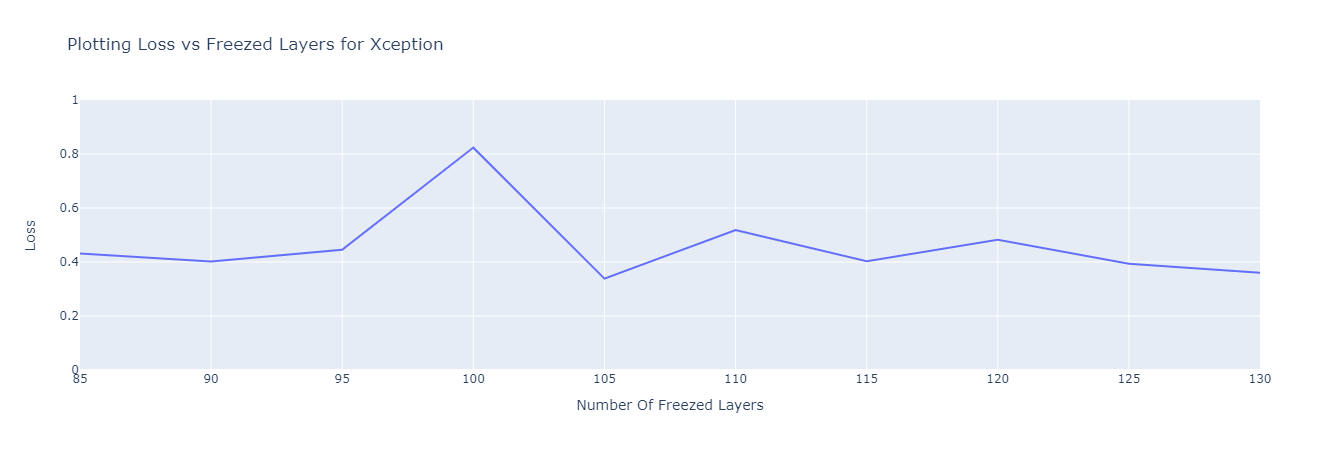

In [215]:
df_xception = getData_xception()
df_xception = df_xception[df_xception.Epoch == 9]
fig = px.line(
    df_xception, 
    x=df_xception['freezed_layer'], 
    y=df_xception['val_loss'],
    title="Plotting Loss vs Freezed Layers for Xception",
).update_layout(xaxis_title="Number Of Freezed Layers", yaxis_title="Loss",yaxis_range=[0.0,1.0])
fig.show()

Plotting the Validation Accuracy vs freezed layers. We observe that as we increase the amount of freezed layers, the accuracy also decreases.

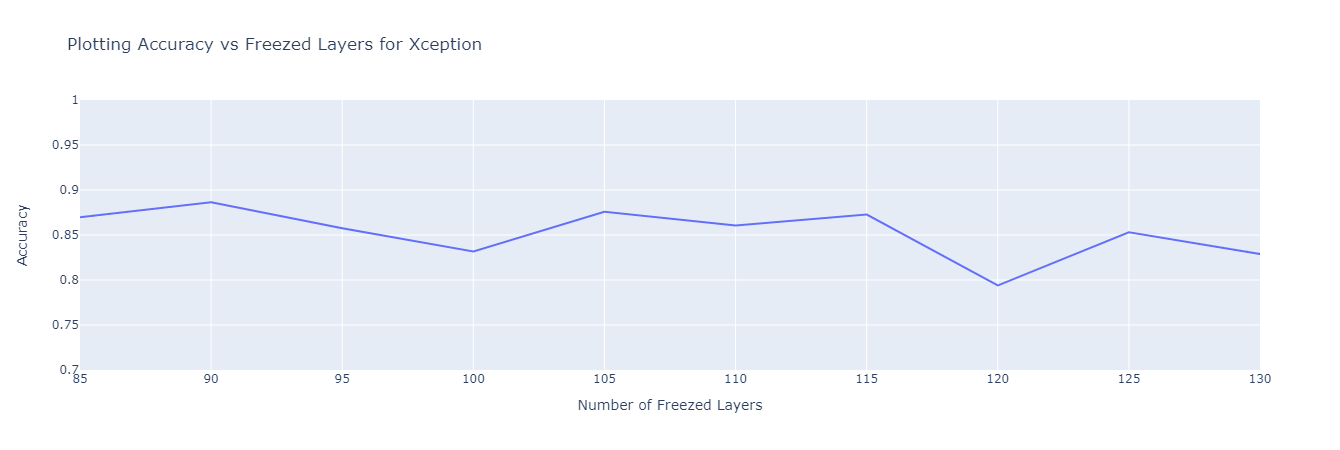

In [216]:
df_xception = getData_xception()
df_xception = df_xception[df_xception.Epoch == 9]
fig = px.line(
    df_xception, 
    x=df_xception['freezed_layer'], 
    y=df_xception['val_binary_accuracy'],
    title="Plotting Accuracy vs Freezed Layers for Xception",
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy",yaxis_range=[0.7,1.0])
fig.show()

Plotting accuracy and loss for the best optimum results achieved and that is for the freezed layers = 105 with the Validation Accuracy = 0.955856263637542 and the Validation Loss = 0.338136255741119. We can conclude that as we increase the epochs, our acuracy increases and the loss decreases.

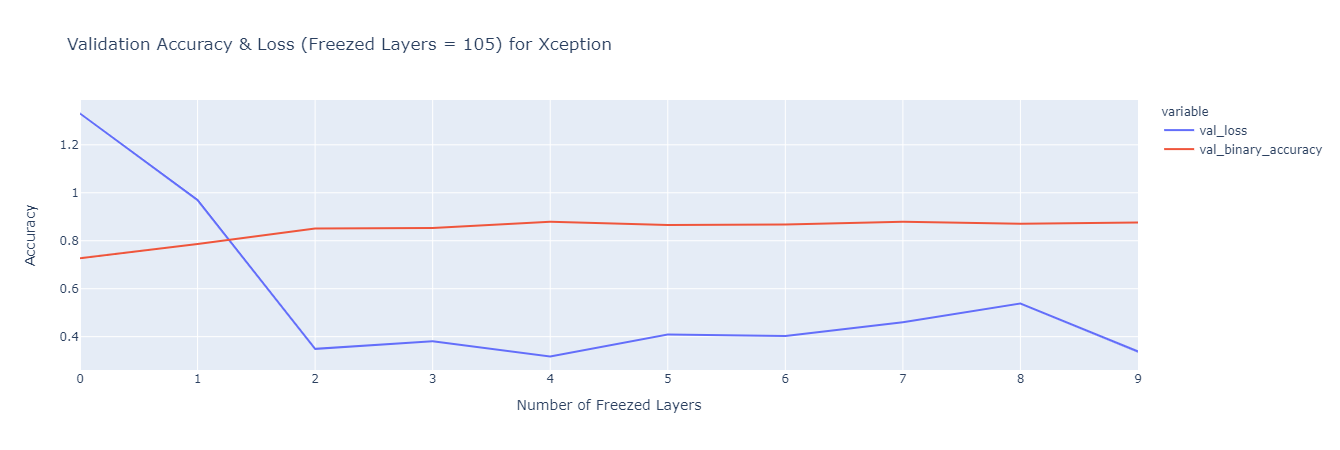

In [218]:
df_xception = getData_xception()
df_xception = df_xception[df_xception.freezed_layer == 105]
fig = px.line(
    df_xception, 
    x='Epoch', 
    y=['val_loss','val_binary_accuracy'],
    title="Validation Accuracy & Loss (Freezed Layers = 105) for Xception"
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy")
fig.show()

Plotting accuracy and loss for the worst results achieved and that is for the freezed layers = 120 with the Accuracy = 0.885546386241912 and the Loss = 0.482201904058456. Although, as the epochs are increased the accuracy and loss and increasing and decreaseing respectively, we have achieved optimum results with freezed layers = 105.

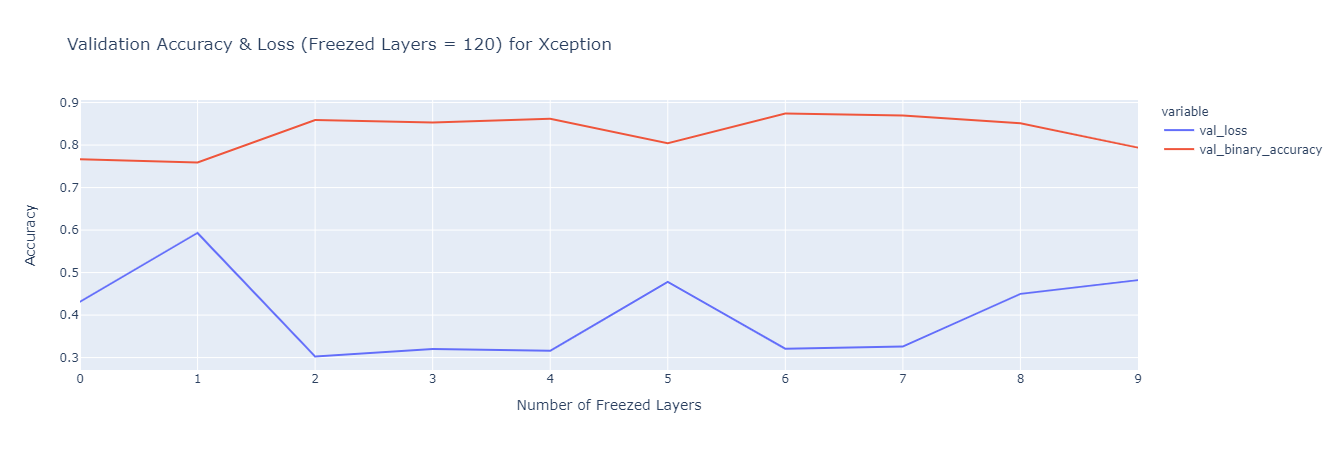

In [219]:
df_xception = getData_xception()
df_xception = df_xception[df_xception.freezed_layer == 120]
fig = px.line(
    df_xception, 
    x='Epoch', 
    y=['val_loss','val_binary_accuracy'],
    title="Validation Accuracy & Loss (Freezed Layers = 120) for Xception"
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy")
fig.show()

# Summary for Xception CNN

The summary of our findings can be shown as below:

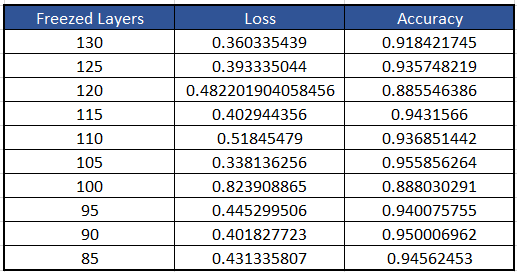

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 105 freezed layers with Accuracy = 0.955856263637542 and Loss = 0.338136255741119.
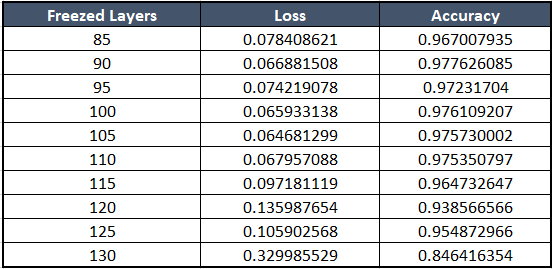

# VGG-16

VGG16 is a convolutional neural network model that is used for image recognition. It is unique in that it has only 16 layers that have weights, as opposed to relying on a large number of hyper-parameters. It is also considered one of the best vision model architectures.

### Base Model for VGG16

We have defined a function "getBaseModel_VGG" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [175]:
def getBaseModel_VGG(freezedLayers):
    model = VGG16(weights="imagenet", include_top=False, input_shape=(imgDim,imgDim,3))
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers for VGG16

A function "getAttachmentForModel_VGG" is defined in which The additional layers are defined for training i.e., 3 hidden (dropout, dense and dense) layers and 1 output layer.

In [176]:
def getAttachmentForModel_VGG(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = layers.Flatten()(X)
    X = layers.Dense(50, activation='relu')(X)
    X = layers.Dense(20, activation='relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model for VGG16

The "getFinalModel_VGG" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [177]:
def getFinalModel_VGG(baseModel):
    attachment = getAttachmentForModel_VGG(baseModel)
    imageInput = Input((299,299,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Train the Model for VGG16

Now, we are training the model. VGG16 CNN model has 16 layers, therefore, we are starting from 14 freezed layers and going down to 10 layers with the difference of 2 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [178]:
for i in range(14,9,-2):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel_vgg = getFinalModel_VGG(getBaseModel_VGG(freezedLayers))
    finalModel_vgg.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel_vgg = finalModel_vgg.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel_vgg,"vgg")

Using 14 freezed layers
58889256/58889256 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
55/55 [==============================] - 81s 1s/step - loss: 0.5258 - binary_accuracy: 0.7277 - auc: 0.8111 - true_positives: 1919.0000 - true_negatives: 1919.0000 - false_positives: 718.0000 - false_negatives: 718.0000 - val_loss: 0.3590 - val_binary_accuracy: 0.8273 - val_auc: 0.9192 - val_true_positives: 546.0000 - val_true_negatives: 546.0000 - val_false_positives: 114.0000 - val_false_negatives: 114.0000
Epoch 2/10
55/55 [==============================] - 63s 1s/step - loss: 0.3697 - binary_accuracy: 0.8294 - auc: 0.9133 - true_positives: 2187.0000 - true_negatives: 2187.0000 - false_positives: 450.0000 - false_negatives: 450.0000 - val_loss: 0.3550 - val_binary_accuracy: 0.8303 - val_auc: 0.9203 - val_true_positives: 548.0000 - val_true_negatives: 548.0000 - val_false_positives: 112.0000 - val_false_negatives: 112.0000
Epoch 3/10
55/55 [==============================] - 62s 1s/step - loss: 0.3475 - binary_accuracy: 0.8350 - auc: 0.9230 - true_positives: 2202.0000 - tru

# Visualizing the Findings for VGG16

Firstly, we will be loading the data from the csv file into a DataFrame.

In [202]:
def getData_vgg():
    df_vgg = pd.read_csv('/kaggle/input/output/vgg.csv')
    df_vgg['Trainable Layers'] = 16 - df_vgg['freezed_layer']
    return df_vgg

Plotting the Validation loss vs freezed layers. We observe that as we increase the amount of freezed layers, the loss also increases.

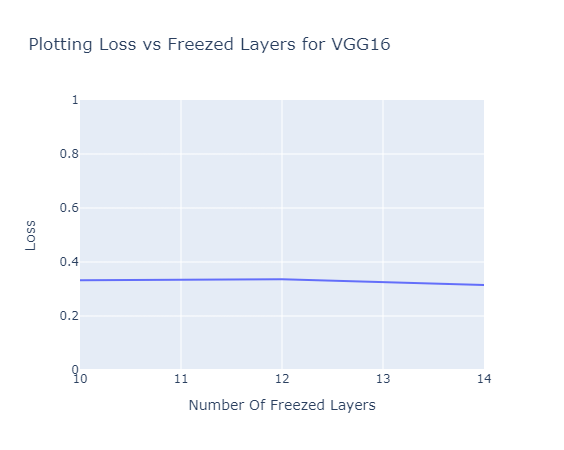

In [203]:
df_vgg = getData_vgg()
df_vgg = df_vgg[df_vgg.Epoch == 9]
fig = px.line(
    df_vgg, 
    x=df_vgg['freezed_layer'], 
    y=df_vgg['val_loss'],
    title="Plotting Loss vs Freezed Layers for VGG16",
).update_layout(xaxis_title="Number Of Freezed Layers", yaxis_title="Loss",yaxis_range=[0.0,1.0])
fig.show()

Plotting the Validation Accuracy vs freezed layers. We observe that as we increase the amount of freezed layers, the accuracy also increases.

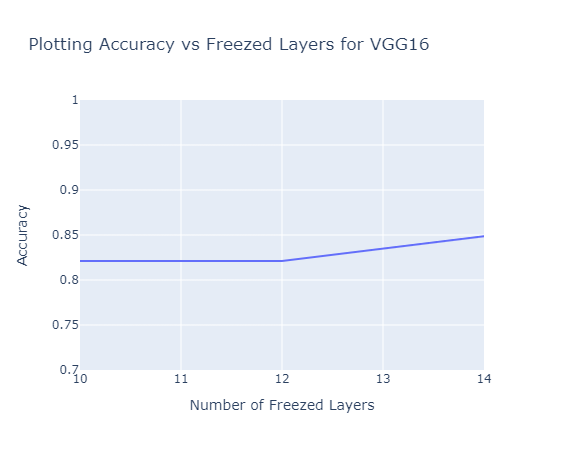

In [204]:
df_vgg = getData_vgg()
df_vgg = df_vgg[df_vgg.Epoch == 9]
fig = px.line(
    df_vgg, 
    x=df_vgg['freezed_layer'], 
    y=df_vgg['val_binary_accuracy'],
    title="Plotting Accuracy vs Freezed Layers for VGG16",
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy",yaxis_range=[0.7,1.0])
fig.show()

Plotting accuracy and loss for the best optimum results achieved and that is for the freezed layers = 14 with the Validation Accuracy = 0.936953723430633 and the Validation Loss = 0.315269231796264. We can conclude that as we increase the epochs, our acuracy increases and the loss decreases.

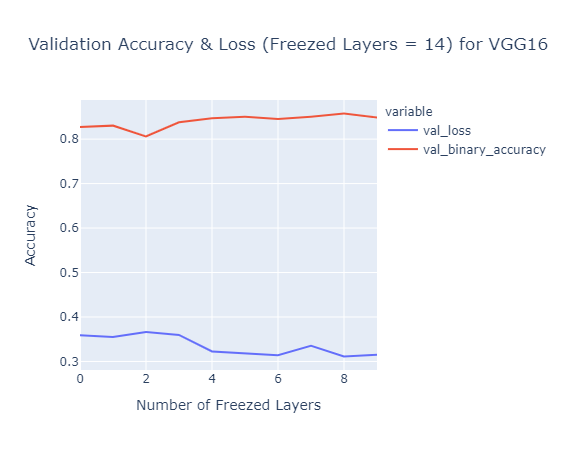

In [205]:
df_vgg = getData_vgg()
df_vgg = df_vgg[df_vgg.freezed_layer == 14]
fig = px.line(
    df_vgg, 
    x='Epoch', 
    y=['val_loss','val_binary_accuracy'],
    title="Validation Accuracy & Loss (Freezed Layers = 14) for VGG16"
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy")
fig.show()

# Summary for VGG16 CNN

The summary of our findings can be shown as below:

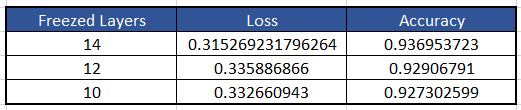

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 14 freezed layers with Accuracy = 0.936953723430633 and Loss = 0.315269231796264.

# Resnet-50

ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.

### Base Model for resnet-50

We have defined a function "getBaseModel_resnet" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [179]:
def getBaseModel_resnet(freezedLayers):
    model = ResNet50(weights="imagenet", include_top=False, input_shape=(imgDim,imgDim,3))
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers for Resnet-50

A function "getAttachmentForModel_resnet" is defined in which The additional layers are defined for training i.e., 4 hidden (flatten, dense, dropout and dense) layers and 1 output layer.

In [180]:
def getAttachmentForModel_resnet(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = Dropout(0.05)(X)
    X = layers.Dense(20, activation='relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model for Resnet-50

The "getFinalModel_resnet" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [181]:
def getFinalModel_resnet(baseModel):
    attachment = getAttachmentForModel_resnet(baseModel)
    imageInput = Input((299,299,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Train the Model for Resnet-50

Now, we are training the model. Resnet-50 CNN model has 50 layers, therefore, we are starting from 45 freezed layers and going down to 33 layers with the difference of 4 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [182]:
for i in range(45,30,-4):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel_resnet = getFinalModel_resnet(getBaseModel_resnet(freezedLayers))
    finalModel_resnet.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel_resnet = finalModel_resnet.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel_resnet,"resnet")

Using 45 freezed layers
94765736/94765736 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
55/55 [==============================] - 92s 1s/step - loss: 0.6639 - binary_accuracy: 0.7353 - auc: 0.8039 - true_positives: 1939.0000 - true_negatives: 1939.0000 - false_positives: 698.0000 - false_negatives: 698.0000 - val_loss: 255.2967 - val_binary_accuracy: 0.5455 - val_auc: 0.5455 - val_true_positives: 360.0000 - val_true_negatives: 360.0000 - val_false_positives: 300.0000 - val_false_negatives: 300.0000
Epoch 2/10
55/55 [==============================] - 64s 1s/step - loss: 0.4140 - binary_accuracy: 0.8039 - auc: 0.8908 - true_positives: 2120.0000 - true_negatives: 2120.0000 - false_positives: 517.0000 - false_negatives: 517.0000 - val_loss: 2.4177 - val_binary_accuracy: 0.4530 - val_auc: 0.4571 - val_true_positives: 299.0000 - val_true_negatives: 299.0000 - val_false_positives: 361.0000 - val_false_negatives: 361.0000
Epoch 3/10
55/55 [==============================] - 64s 1s/step - loss: 0.4046 - binary_accuracy: 0.8062 - auc: 0.8945 - true_positives: 2126.0000 - t

# Visualizing the Findings for Resnet-50

Firstly, we will be loading the data from the csv file into a DataFrame.

In [208]:
def getData_resnet():
    df_resnet = pd.read_csv('/kaggle/input/output/resnet.csv')
    df_resnet['Trainable Layers'] = 50 - df_resnet['freezed_layer']
    return df_resnet

Plotting the Validation loss vs freezed layers. We observe that as we increase the amount of freezed layers, the loss also increases.

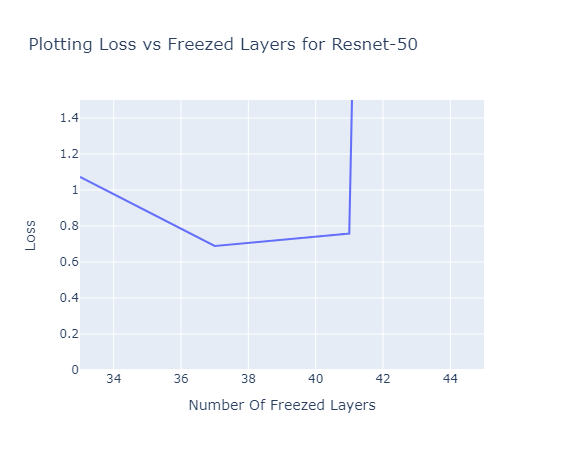

In [210]:
df_resnet = getData_resnet()
df_resnet = df_resnet[df_resnet.Epoch == 9]
fig = px.line(
    df_resnet, 
    x=df_resnet['freezed_layer'], 
    y=df_resnet['val_loss'],
    title="Plotting Loss vs Freezed Layers for Resnet-50",
).update_layout(xaxis_title="Number Of Freezed Layers", yaxis_title="Loss",yaxis_range=[0.0,1.5])
fig.show()

Plotting the Validation Accuracy vs freezed layers. We observe that as we increase the amount of freezed layers, the accuracy also increases.

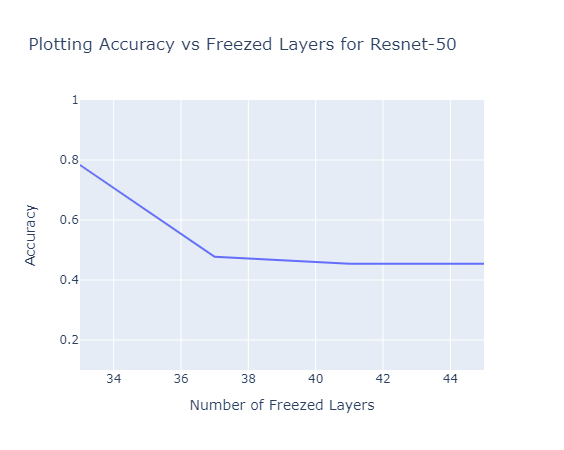

In [213]:
df_resnet = getData_resnet()
df_resnet = df_resnet[df_resnet.Epoch == 9]
fig = px.line(
    df_resnet, 
    x=df_resnet['freezed_layer'], 
    y=df_resnet['val_binary_accuracy'],
    title="Plotting Accuracy vs Freezed Layers for Resnet-50",
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy",yaxis_range=[0.1,1.0])
fig.show()

Plotting accuracy and loss for the best optimum results achieved and that is for the freezed layers = 33 with the Validation Accuracy = 0.783333361148834 and the Validation Loss = 0.783333361148834. We can conclude that as we increase the epochs, our acuracy increases and the loss decreases.

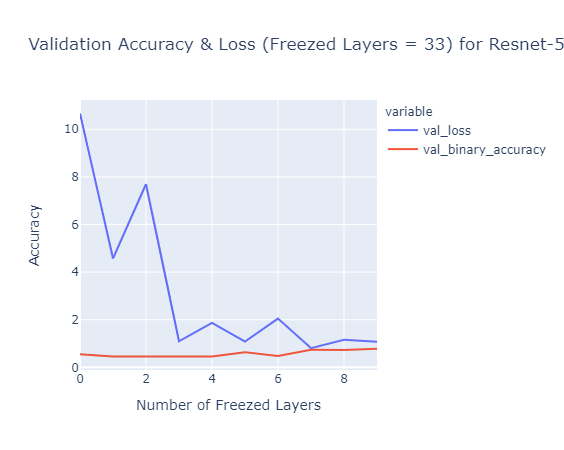

In [214]:
df_resnet = getData_resnet()
df_resnet = df_resnet[df_resnet.freezed_layer == 33]
fig = px.line(
    df_resnet, 
    x='Epoch', 
    y=['val_loss','val_binary_accuracy'],
    title="Validation Accuracy & Loss (Freezed Layers = 33) for Resnet-50"
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy")
fig.show()

# Summary for Resnet-50 CNN

The summary of our findings can be shown as below:

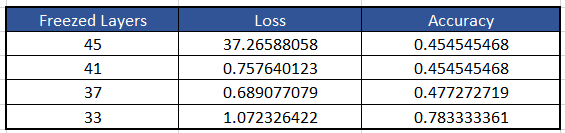

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 33 freezed layers with Accuracy = 0.783333361148834 and Loss = 1.07232642173767.

# Conclusion

The results found for Xception, VGG16 and Resnet-50 can be summarized as below:

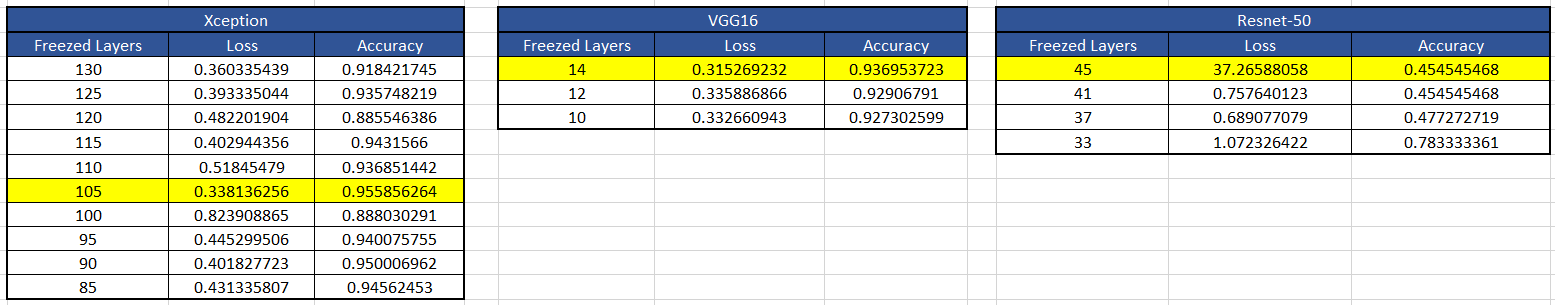

The yellow highlighted row is the best result for each model.

### The best model is the Xception Convolution Neural Network with 105 freezed layers having the Accuracy of 0.955856263637542 and the Loss of 0.338136255741119.
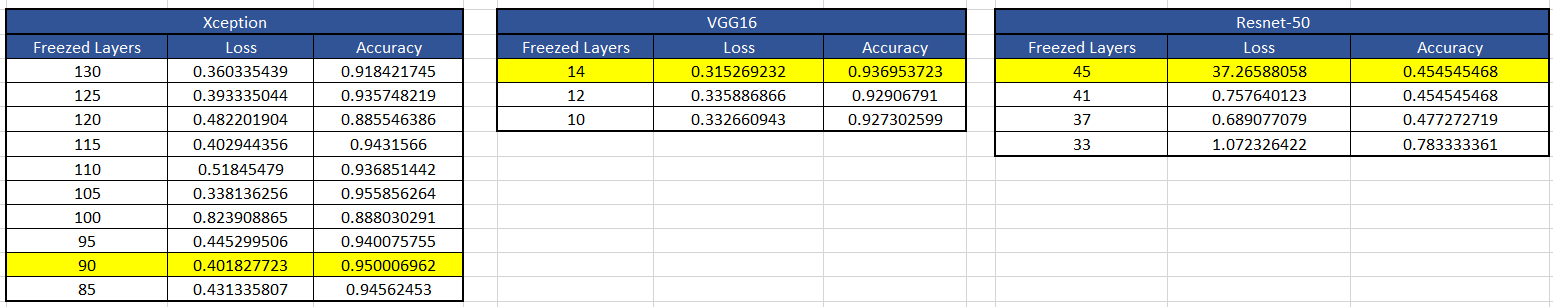

# Future Scope

The future scope involves training for more epochs, however, that would require more computational power and we can explore that option if given more time.

Furthermore, this application can be deployed to test and eventually production environment if it passes all the necessary approvals and compliances.

# References

1. https://www.kaggle.com/code/danushkumarv/skin-cancer-detection-deep-cnn/notebook This notebook is used for the code guidance and as a baseline configuration.

2. https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign Dataset for skin cancer detection was used from here.